In [1]:
import pandas as pd

In [13]:
df=pd.read_csv("data.csv",index_col=0)
df.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [31]:
df=df.query("`label` in ['Angry','Surprise','Ahegao']")
df=df.reset_index(drop=True)
df['path']="dataset/"+df['path']

In [14]:
import torch
from torchvision import transforms
from PIL import Image

In [47]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((255,255)),
])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    'Data',
    transform=train_transforms,
)

In [51]:
dataset_train

Dataset ImageFolder
    Number of datapoints: 3752
    Root location: Data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(255, 255), interpolation=bilinear, max_size=None, antialias=True)
           )

In [56]:
from torch.utils.data import DataLoader
dataloader_train = DataLoader(dataset_train,shuffle=True,batch_size=100,)
image, label = next(iter(dataloader_train))
print(image.shape)

torch.Size([100, 3, 255, 255])


In [53]:
image[0].shape

torch.Size([3, 255, 255])

torch.Size([255, 255, 3])


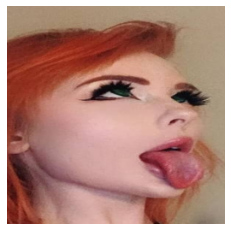

In [58]:
import matplotlib.pyplot as plt
temp = image[0].squeeze().permute(1, 2, 0,) 
print(temp.shape)
# Display the image
plt.imshow(temp)
plt.axis('off')
plt.show()

In [68]:
label[0].item()

0

In [69]:
label[0].keys()

AttributeError: 'Tensor' object has no attribute 'keys'